In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.stats import normaltest
import scikit_posthocs as sp

In [27]:
file_path = "Pairwise Cluster Comparisons - FINAL.txt"
df = pd.read_csv(file_path, sep="\t")

In [28]:
family_cols = [col for col in df.columns if col.startswith("Family_")]

In [29]:
summary = []
for col in family_cols:
    yes_count = (df[col] == "Yes").sum()
    no_count = (df[col] == "No").sum()
    total = yes_count + no_count
    summary.append({
        "Family Column": col,
        "Homologous (Yes)": yes_count,
        "Non-Homologous (No)": no_count,
        "Total Pairs": total,
        "Percent Homologous": round(100 * yes_count / total, 2)
    })

In [32]:
summary_df = pd.DataFrame(summary)
display(summary_df)

,Family Column,Homologous (Yes),Non-Homologous (No),Total Pairs,Percent Homologous
0,Family_1_8,703,2346158,2346861,0.03
1,Family_2_8,1109,2345752,2346861,0.05
2,Family_1_7,1106,2345755,2346861,0.05
3,Family_2_7,2265,2344596,2346861,0.10
4,Family_3_8,1962,2344899,2346861,0.08
5,Family_1_6,2247,2344614,2346861,0.10


In [35]:
melted = df.melt(
    id_vars=["Jaccard"],
    value_vars=family_cols,
    var_name="Family",
    value_name="Homology"
)

melted["Homology"] = melted["Homology"].map({"Yes": "Homologous", "No": "Non-Homologous"})
melted["Family"] = melted["Family"].str.replace("Family_", "HRC", regex=False) # replace Family with homology region class (HRC)

In [ ]:
# Statistical Tests

In [54]:
# Checking for normality - D'Agostino and Pearson's test

In [36]:
normality_results = []

for fam in melted["Family"].unique():
    sub_df = melted[melted["Family"] == fam]
    for group in ["Homologous", "Non-Homologous"]:
        scores = sub_df[sub_df["Homology"] == group]["Jaccard"]

        if len(scores) >= 20:  
            stat, p = normaltest(scores)
            normality_results.append({
                "Family": fam,
                "Group": group,
                "n": len(scores),
                "Normality Test p-value": p,
                "Normal?": "Yes" if p >= 0.05 else "No"
            })

normality_df = pd.DataFrame(normality_results)
display(normality_df)

,Family,Group,n,Normality Test p-value,Normal?
0,HRC1_8,Homologous,703,4.589677e-44,No
1,HRC1_8,Non-Homologous,2346158,0.000000e+00,No
2,HRC2_8,Homologous,1109,4.926683e-30,No
3,HRC2_8,Non-Homologous,2345752,0.000000e+00,No
4,HRC1_7,Homologous,1106,3.454954e-25,No
5,HRC1_7,Non-Homologous,2345755,0.000000e+00,No
6,HRC2_7,Homologous,2265,3.138055e-77,No
7,HRC2_7,Non-Homologous,2344596,0.000000e+00,No
8,HRC3_8,Homologous,1962,0.000000e+00,No
9,HRC3_8,Non-Homologous,2344899,0.000000e+00,No


In [37]:
test_results = []

for fam in melted["Family"].unique():
    sub_df = melted[melted["Family"] == fam]
    jacc_hom = sub_df[sub_df["Homology"] == "Homologous"]["Jaccard"]
    jacc_non_full = sub_df[sub_df["Homology"] == "Non-Homologous"]["Jaccard"]

    # Downsample non-homologous to match homologous count
    jacc_non = jacc_non_full.sample(n=len(jacc_hom), random_state=42)

    stat, p_value = mannwhitneyu(jacc_hom, jacc_non, alternative="two-sided")

    test_results.append({
        "Family": fam,
        "n Homologous": len(jacc_hom),
        "n NonHomologous (sampled)": len(jacc_non),
        "Median Homologous": jacc_hom.median(),
        "Median NonHomologous": jacc_non.median(),
        "Mann-Whitney U": stat,
        "p-value": p_value
    })

In [39]:
test_df = pd.DataFrame(test_results)
display(test_df)

,Family,n Homologous,n NonHomologous (sampled),Median Homologous,Median NonHomologous,Mann-Whitney U,p-value
0,HRC1_8,703,703,0.906832,0.225806,491293.0,8.185241e-226
1,HRC2_8,1109,1109,0.814815,0.235294,1179960.5,3.037791e-307
2,HRC1_7,1106,1106,0.817091,0.238095,1134123.5,3.473692e-265
3,HRC2_7,2265,2265,0.613636,0.225610,4352457.0,0.000000e+00
4,HRC3_8,1962,1962,0.562500,0.234305,2947875.5,7.624080e-183
5,HRC1_6,2247,2247,0.476190,0.237500,3797213.5,2.774013e-188


In [40]:
#Dunn's post-hoc test between families

homologous_df = melted[melted["Homology"] == "Homologous"]

dunn_results = sp.posthoc_dunn(
    homologous_df,
    val_col="Jaccard",
    group_col="Family",
    p_adjust="fdr_bh"
)

dunn_results.index.name = "Family"
dunn_results.columns.name = "Comparison With"

display(dunn_results)

Comparison With,HRC1_6,HRC1_7,HRC1_8,HRC2_7,HRC2_8,HRC3_8
Family,,,,,,
HRC1_6,1.000000e+00,3.574243e-85,3.203821e-179,2.923867e-13,1.854946e-112,3.082157e-04
HRC1_7,3.574243e-85,1.000000e+00,1.185267e-26,1.909601e-42,1.050175e-02,1.692942e-58
HRC1_8,3.203821e-179,1.185267e-26,1.000000e+00,1.399892e-122,3.246784e-17,1.320550e-143
HRC2_7,2.923867e-13,1.909601e-42,1.399892e-122,1.000000e+00,4.589676e-62,6.650379e-04
HRC2_8,1.854946e-112,1.050175e-02,3.246784e-17,4.589676e-62,1.000000e+00,1.066821e-80
HRC3_8,3.082157e-04,1.692942e-58,1.320550e-143,6.650379e-04,1.066821e-80,1.000000e+00


In [ ]:
# Violin plot with Jaccard index distributions

In [41]:
def pval_to_stars(p):
    if p < 0.0001:
        return "****"
    elif p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

Save plot as PNG? (yes/no):  yes


Plot saved as jaccard_violinplot_withMann.png


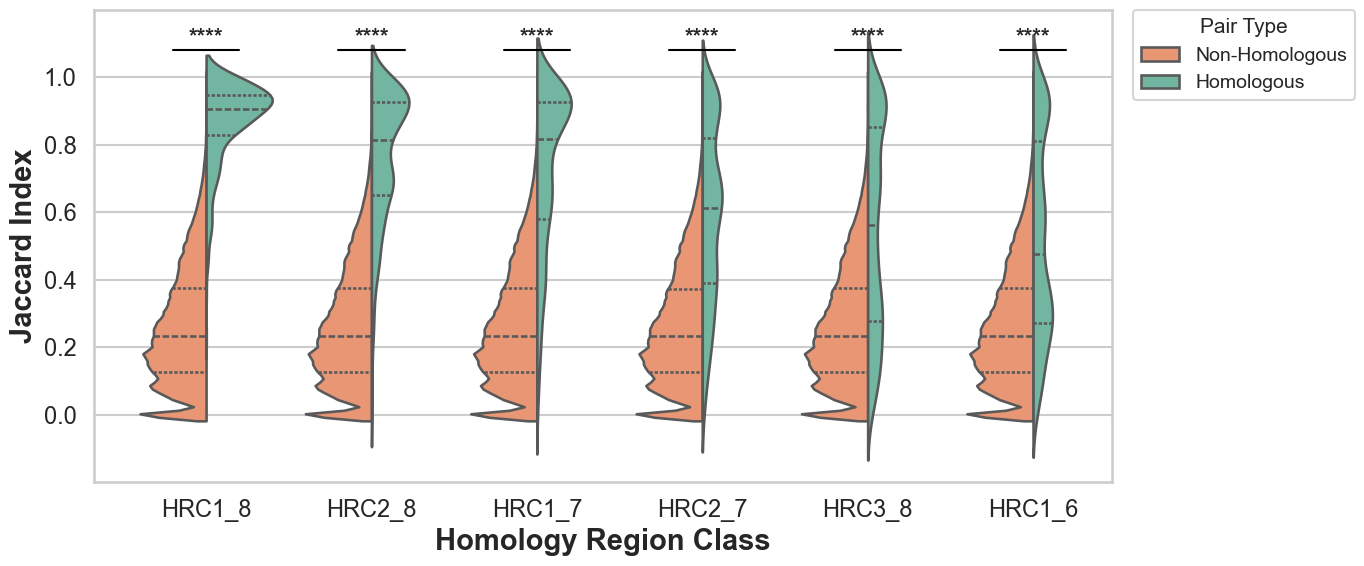

In [25]:
sns.set(style="whitegrid", context="talk")
palette_dict = {
    "Homologous": "#66c2a5",
    "Non-Homologous": "#fc8d62"
}

plt.figure(figsize=(14, 6))
ax = sns.violinplot(
    data=melted,
    x="Family",
    y="Jaccard",
    hue="Homology",
    split=True,
    inner="quartile",
    palette=palette_dict,
)

test_results = []
families = sorted(melted["Family"].unique())

for i, fam in enumerate(families):
    sub_df = melted[melted["Family"] == fam]
    jacc_hom = sub_df[sub_df["Homology"] == "Homologous"]["Jaccard"]
    jacc_non_full = sub_df[sub_df["Homology"] == "Non-Homologous"]["Jaccard"]
    jacc_non = jacc_non_full.sample(n=len(jacc_hom), random_state=42)

    stat, p_value = mannwhitneyu(jacc_hom, jacc_non, alternative="two-sided")
    stars = pval_to_stars(p_value)

    test_results.append({
        "Family": fam,
        "n Homologous": len(jacc_hom),
        "n NonHomologous (sampled)": len(jacc_non),
        "Median Homologous": jacc_hom.median(),
        "Median NonHomologous": jacc_non.median(),
        "Mann-Whitney U": stat,
        "p-value": p_value
    })

    y_max = melted["Jaccard"].max() + 0.08
    x1, x2 = i - 0.2, i + 0.2
    plt.plot([x1, x2], [y_max, y_max], color='black', linewidth=1.5)
    plt.text((x1 + x2) / 2, y_max + 0.01, stars, ha='center', va='bottom', fontsize=16, fontweight="bold")

plt.ylabel("Jaccard Index", fontsize=21, fontweight="bold")
plt.xlabel("Homology Region Class", fontsize=21, fontweight="bold")
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.ylim(-0.2, 1.2)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.legend(title="Pair Type", title_fontsize=15, fontsize=14, loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.tight_layout()

save = input("Save plot as PNG? (yes/no): ").strip().lower()
if save == 'yes':
    plt.savefig("jaccard_violinplot_withMann.png", dpi=300, bbox_inches='tight')
    print("Plot saved as jaccard_violinplot_withMann.png")

plt.show()

In [80]:
# Dunn Test heatmap

C:\Users\moris\AppData\Local\Temp\ipykernel_3532\2811450629.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dunn_stars = dunn_results.applymap(pval_to_stars)
C:\Users\moris\AppData\Local\Temp\ipykernel_3532\2811450629.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dunn_scores = dunn_stars.replace(star_to_score)


Save plot as PNG? (yes/no):  yes


Plot saved as Heatmap Dunn.png


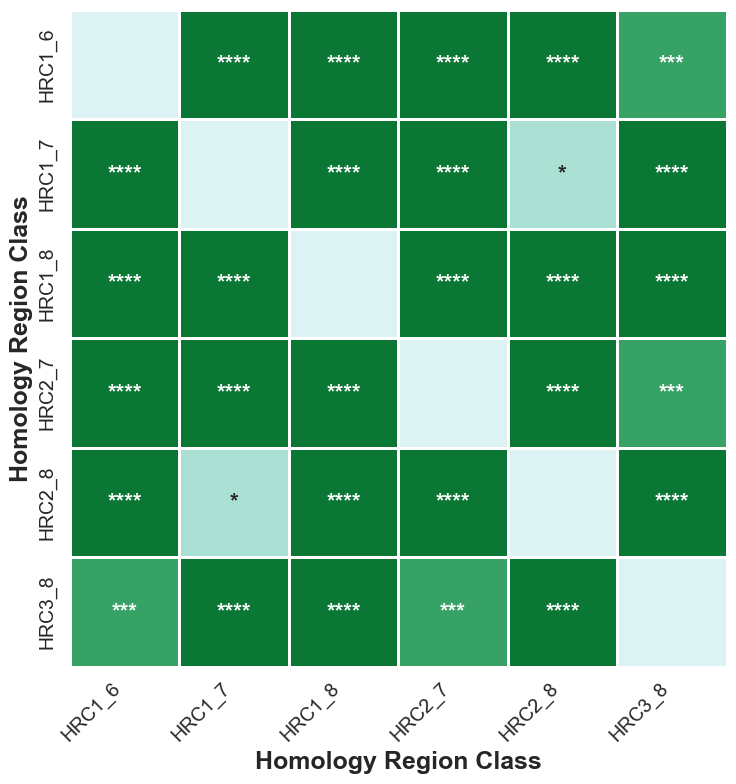

In [53]:
dunn_stars = dunn_results.applymap(pval_to_stars)
star_to_score = {"": 0, "*": 1, "**": 2, "***": 3, "****": 4}
dunn_scores = dunn_stars.replace(star_to_score)

pastel_green = sns.color_palette("BuGn", n_colors=5)

plt.figure(figsize=(10, 8))
sns.set(style="white")

sns.heatmap(
    dunn_scores,
    annot=dunn_stars,
    fmt='',
    cmap=pastel_green,
    linewidths=1,
    linecolor='white',
    square=True,
    cbar=False,
    annot_kws={"fontsize": 16, "weight": "bold"}
)

plt.xlabel("Homology Region Class", fontsize=18, fontweight='bold')
plt.ylabel("Homology Region Class", fontsize=18, fontweight='bold')
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.yticks(fontsize=14)
plt.tight_layout()

save = input("Save plot as PNG? (yes/no): ").strip().lower()
if save == 'yes':
    plt.savefig("Heatmap Dunn.png", dpi=300, bbox_inches='tight')
    print("Plot saved as Heatmap Dunn.png")

plt.show()